___

# <font color= #f6c049> **Soda Pop Project: Data Processing** </font>
#### <font color= #2E9AFE> `Deep Learning`</font>
<Strong> Sofía Maldonado, Óscar Josué Rocha & Viviana Toledo </Strong>

_27/02/2026._

___

In [12]:
# General
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# # Run on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Models
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from keras.optimizers import Adam
from keras import Model

# Loss Function
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Model, Input

In [13]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# <font color= #f6c049> **Modeling** </font>

The selected model architecture for the image generation task will be a **Convolutional Autoencoder with a Perceptual loss function using VGG-19**. 

## <font color= #dba226> &ensp; • **Perceptual Loss with VGG Model** </font>

The final convolutional layer from the VGG19 model is going to be extracted to use as a loss function. This layer contains deep patterns captured during training. The weights of the model will be freezed so that no more training is performed, and the layer is only used to compare the input images versus the generated ones.

In [14]:
def get_vgg_model():
    # Get VGG model trained with imagenet, with no fixed input shape
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(None, None, 3))
    vgg.trainable = False           # Freeze weights
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    loss_model.trainable = False
    return loss_model

vgg_model = get_vgg_model()

With the previously extracted layer, a customized loss function is defined by calculating the difference between predicted and true images:

In [15]:
def perceptual_loss(y_true, y_pred):
    y_true_features = vgg_model(y_true)
    y_pred_features = vgg_model(y_pred)
    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))

## <font color= #dba226> &ensp; • **Convolutional Autoencoder** </font>

Before starting the CAE, we import the previously normalized and resized images:

In [16]:
train_ds = tf.data.Dataset.load('../data/processed/train_ds')
val_ds = tf.data.Dataset.load('../data/processed/val_ds')
test_ds = tf.data.Dataset.load('../data/processed/test_ds')

The images have a size of 256x256 pixels. Thus, the dimensionality reduction within the autoencoder will be done as follows:

$$
65,536_{input}  \rightarrow 16,384_{h_1} \rightarrow 4096_{h_2} \rightarrow 1024_{h_3} \rightarrow 256_z \leftarrow 1024_{h_3} \leftarrow 4096_{h_2} \leftarrow 16,384_{h_1} \leftarrow 65,536_{output}
$$

The hyperparameters of the Convolutional Autoencoder will be:

- Optimizer: Adam
- Loss: Perceptual Loss
- Epochs: 5

In [17]:
# Parameters
input_shape = (64,64,3)         # 4096

# Input 
input_layer = Input(shape=input_shape)

# Encoder
enc_layer_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(input_layer)         # 16x16             
enc_max_pool_1 = MaxPooling2D(pool_size=(2,2))(enc_layer_1)

enc_layer_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(enc_max_pool_1)             
enc_max_pool_2 = MaxPooling2D(pool_size=(2,2))(enc_layer_2)

enc_layer_3 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(enc_max_pool_2)             
enc_max_pool_3 = MaxPooling2D(pool_size=(2,2))(enc_layer_3)


In [18]:
# Decoder
dec_layer_1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(enc_max_pool_3)
dec_up_sampling_1 = UpSampling2D(size=(2,2))(dec_layer_1)

dec_layer_2 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(dec_up_sampling_1)
dec_up_sampling_2 = UpSampling2D(size=(2,2))(dec_layer_2)

dec_layer_3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(dec_up_sampling_2)
dec_up_sampling_3 = UpSampling2D(size=(2,2))(dec_layer_3)

# Concatenate
dec_up_sampling_3 = Concatenate()([dec_up_sampling_3, enc_layer_1])
concat = Dropout(0.3)(dec_up_sampling_3)

decoded = Conv2D(3, kernel_size=3, activation='sigmoid', padding='same')(concat)

In [19]:
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss=perceptual_loss)
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     36,928 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │     18,464 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 32)  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 32)  │      9,248 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 16, 16,    │          0 │ conv2d_10[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │      9,248 │ up_sampling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ conv2d_11[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │     18,496 │ up_sampling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ up_sampling2d_5[… │
│ (Concatenate)       │ 128)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64, 3) │      3,459 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 97,635 (381.39 KB)

 Trainable params: 97,635 (381.39 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
autoencoder.fit(train_ds, batch_size=64, epochs=5, validation_data=(val_ds))

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.0656 - val_loss: 0.0584
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0472 - val_loss: 0.0295
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0233 - val_loss: 0.0158
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0127 - val_loss: 0.0077
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0062 - val_loss: 0.0038


In [21]:
preds = autoencoder.predict(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


2026-02-27 09:13:51.743342: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


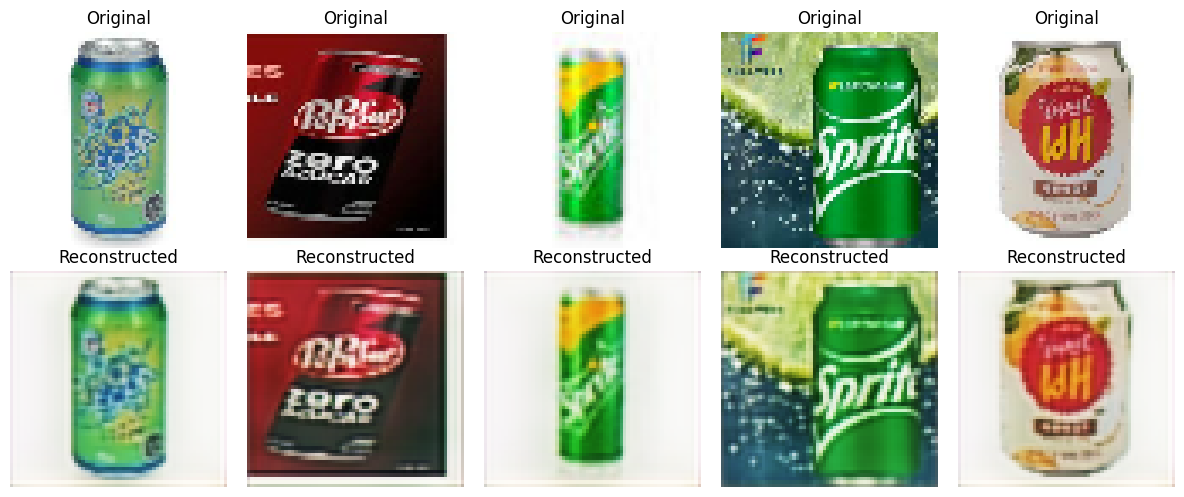

In [22]:
# Extract images from test
ogs = np.concatenate([x.numpy() for x, _ in test_ds], axis=0)

# Plot 5 images
n = 5
plt.figure(figsize=(12, 5))

for i in range(n):
    # Original images
    plt.subplot(2, n, i + 1)
    plt.imshow(ogs[i])
    plt.title("Original")
    plt.axis("off")

    # Generated images
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(preds[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()